In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import torch

warnings.filterwarnings('ignore')

In [2]:
def RFF_sample(n, shape):
    w = torch.randn(n)
    phi = 2*np.pi*torch.rand(n)
    if(shape == 2):
        return lambda x:np.sqrt(2)*torch.cos(w[:,None]*x[None,:]+phi[:,None])
    else:
        return lambda x:np.sqrt(2)*torch.cos(w[:,None,None]*x[None,:,:]+phi[:,None,None])

def hat_sigma(A, B, weights):
    nA, n, _ = A.shape
    wA = (weights[None,:, None]*A - torch.mean(weights[None,:, None]*A, axis=1)[:, None, :]).transpose(0,1).transpose(1,2)[:,:,:,None]
    wB = (weights[None, :]*B - torch.mean(weights[None, :]*B, axis=1)[:, None]).transpose(0,1)[:,None,None,:]
    return torch.sum(wA*wB, axis=0)/(n-1)

def F_norm2(A, i):
    return torch.sum(A**2) - torch.sum(A[i]**2)

u, v = RFF_sample(5,3), RFF_sample(5,2)
X, Y = torch.randn((10000, 64)), torch.randn(10000)
print(F_norm2(hat_sigma(u(X), v(Y), torch.ones(10000)), 0))
print(F_norm2(hat_sigma(u(X), v(X[:,0]**2), torch.ones(10000)), 0))

tensor(0.0148)
tensor(0.0175)


In [3]:
import torch.nn as nn
import torch.nn.functional as F
    
class AttentionRepresentation(nn.Module):
    def __init__(self, n_team_fts, hidden_team):
        super().__init__()
        self.hidden = hidden_team
        self.bc1 = nn.BatchNorm1d(n_team_fts)
        self.bc2 = nn.BatchNorm1d(hidden_team)
        self.att1 = nn.MultiheadAttention(hidden_team, 1, batch_first=True)
        self.fc1 = nn.Linear(n_team_fts, hidden_team)

    def forward(self, x):
        res = self.bc2(self.fc1(self.bc1(x)))[:,None,:]
        res = self.att1(res, res, res, need_weights=False)[0]
        return res[:,0,:]
    
    def activate(self, require):
        self.bc1.requires_grad_(require)
        self.bc2.requires_grad_(require)
        self.att1.requires_grad_(require)
        self.fc1.requires_grad_(require)
    

class MatchTeamClassifier(nn.Module):
    def __init__(self, n_class, n_team_fts, hidden_team):
        super().__init__()
        self.phi = AttentionRepresentation(n_team_fts, hidden_team)
        self.fc = nn.Linear(hidden_team, n_class)

    def forward(self, x):
        return self.fc(self.phi(x))
    
    def activate(self, require):
        self.phi.activate(require)
        self.fc.requires_grad_(require)

In [4]:
train_home_player_statistics_df = pd.read_csv('./train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('./train_away_player_statistics_df.csv', index_col=0)
train_home_team_statistics_df = pd.read_csv('./train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./train_away_team_statistics_df.csv', index_col=0)
train_home_team_statistics_df.columns = 'HOME_' + train_home_team_statistics_df.columns
train_away_team_statistics_df.columns = 'AWAY_' + train_away_team_statistics_df.columns


train_scores = pd.read_csv('./Y_train.csv', index_col=0)

import pickle

lin_model_position = pickle.load(open("pos_model", "rb"))
encoding = ["attacker", "defender", "goalkeeper", "midfielder"]


train_home_player_statistics_df.loc[train_home_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(train_home_player_statistics_df.iloc[:,4:].replace({np.nan:0.0}))])[train_home_player_statistics_df.isna()["POSITION"]]
train_away_player_statistics_df.loc[train_away_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(train_away_player_statistics_df.iloc[:,4:].replace({np.nan:0.0}))])[train_away_player_statistics_df.isna()["POSITION"]]

df = train_away_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_away = df.set_index("ID").groupby("POSITION")
positions = ["attacker", "goalkeeper", "midfielder", "defender"]
m1 = np.intersect1d(gb_away.get_group(positions[0]).index, gb_away.get_group(positions[1]).index)
m2 = np.intersect1d(gb_away.get_group(positions[2]).index, gb_away.get_group(positions[3]).index)
away_m = np.intersect1d(m1, m2)

df = train_home_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_home = df.set_index("ID").groupby("POSITION")
m1 = np.intersect1d(gb_home.get_group(positions[0]).index, gb_home.get_group(positions[1]).index)
m2 = np.intersect1d(gb_home.get_group(positions[2]).index, gb_home.get_group(positions[3]).index)
home_m = np.intersect1d(m1, m2)

m = np.intersect1d(away_m, home_m)

train_player_data = []
useless_features = open("lines.txt", "r").readlines()
useless_features = [ft[:-1] for ft in useless_features]
print(useless_features)
for pos in positions:
    df_home_pos = gb_home.get_group(pos).drop(useless_features, axis=1)
    df_away_pos = gb_away.get_group(pos).drop(useless_features, axis=1)
    df_home_pos.columns = 'HOME_' + df_home_pos.columns
    df_away_pos.columns = 'AWAY_' + df_away_pos.columns
    train_player_data.append(df_home_pos.iloc[:,1:].join(df_away_pos.iloc[:,1:]))

train_player_data[0].columns = "ATTACK_" + train_player_data[0].columns
train_player_data[1].columns = "GOALKEEP_" + train_player_data[1].columns
train_player_data[2].columns = "MIDFIELD_" + train_player_data[2].columns
train_player_data[3].columns = "DEFEND_" + train_player_data[3].columns

train_data = train_home_team_statistics_df.iloc[m,2:].join(train_away_team_statistics_df.iloc[m,2:].join(train_player_data[0].loc[m,:].join(train_player_data[1].loc[m,:].join(train_player_data[2].loc[m,:].join(train_player_data[3].loc[m,:])))))

select_fts = open("feature_selection.txt", "r").readlines()
select_fts = [ft[:-1] for ft in select_fts]
train_data = train_data[select_fts]
print(train_data)

['PLAYER_CAPTAIN_5_last_match_average', 'PLAYER_CAPTAIN_5_last_match_std', 'PLAYER_CAPTAIN_season_average', 'PLAYER_CAPTAIN_season_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_average', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_sum', 'PLAYER_LONG_BALLS_5_last_match_average', 'PLAYER_LONG_BALLS_5_last_match_std', 'PLAYER_LONG_BALLS_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_5_last_match_average', 'PLAYER_LONG_BALLS_WON_5_last_match_std', 'PLAYER_LONG_BALLS_WON_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_season_average', 'PLAYER_LONG_BALLS_WON_season_std', 'PLAYER_LONG_BALLS_WON_season_sum', 'PLAYER_LONG_BALLS_season_average', 'PLAYER_LONG_BALLS_season_std', 'PLAYER_LONG_BALLS_season_sum', 'PLAYER_PENALTIES_SAVED_5_last_match_average', 'PLAYER_PENALTIES_SAVED_5_last_match_std', 'PLAYER_PENALTIES_SAVED_5_last_match_sum', 'PLAYER_PENALTIES_SAVED_season_average', 'PLAYER_PENALTIES_SAVED_season_std', 'PLAYER_PENALTIES_SAVED_season_sum', 'PLAYER_PENALTIE

In [6]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_data, train_scores.iloc[m,:], train_size=0.8, random_state=42)

In [7]:
net = MatchTeamClassifier(3, 512, 64)

x_train = torch.Tensor(X_train.replace({np.nan:0.0}).values)
x_valid = torch.Tensor(X_valid.replace({np.nan:0.0}).values)
Y_train = torch.Tensor(y_train.values)
Y_valid = torch.Tensor(y_valid.values)

print(net(x_valid).shape)
net.phi.bc1.requires_grad_(False)


torch.Size([2125, 3])


BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [33]:
from torchmin import minimize_constr
def Frobenius_loss(A, B, u, v):
    _, d = B.shape
    def Loss(weights):
        loss = torch.tensor(0.0)
        for i in range(d):
            loss += F_norm2(hat_sigma(u(A), v(B[:,i]), weights), i)
        return loss
    return Loss

torch.set_grad_enabled(True)
u, v = RFF_sample(5,3), RFF_sample(5,2)
X, Y = net.phi(x_train), net.phi(x_train)
res = minimize_constr(Frobenius_loss(net.phi(x_train), net.phi(x_train), u, v), torch.ones(x_train.shape[0]), max_iter=10, constr=dict(fun=lambda x: x.mean(), lb=1, ub=1),disp=2)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [8]:
import copy

torch.set_flush_denormal(True)
N_EPOCHS = 10000 # + 100
net.train()
criterion = nn.CrossEntropyLoss(reduction='none') # loss

optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-2)

sample_weights = torch.ones(x_train.shape[0])
weights_optimizer = torch.optim.Adam([sample_weights], lr=0.005, weight_decay=5e-2)
u, v = RFF_sample(5,3), RFF_sample(5,2)
weight_rate = 1

train_accuracies = [1.0]
val_accuracies = [1.0]
val_check = 1
best_state, best_val = None, 0.0
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    # Iterate over batches and perform optimizer step on the model.
    sample_weights.requires_grad_(False)
    net.activate(True)
    optimizer.zero_grad()
    y_pred = net(x_train)
    loss = criterion(y_pred, Y_train)
    loss = (loss*sample_weights).mean()
    loss.backward()
    optimizer.step()

    # perform optimizer step on the sample weights
    sample_weights.requires_grad_(True)
    net.activate(False)

    for j in range(weight_rate):
        weights_optimizer.zero_grad()
        F_loss = torch.tensor(0.0)
        for i in range(64):
            F_loss += F_norm2(hat_sigma(u(net.phi(x_train)), v(net.phi(x_train)[:,i]), sample_weights), i)
    
        F_loss += 500/(sample_weights).mean()
        F_loss.backward()
        weights_optimizer.step()
        print("moy(w) = ", sample_weights.mean().item())
        
    train_acc, val_acc = accuracy_score(torch.argmax(y_pred, axis=1), torch.argmax(Y_train, axis=1)), val_accuracies[-1]
    if(epoch % val_check == 0):
        hat_y_val = net(x_valid)
        #val_loss = criterion(hat_y_val, y_val)
        val_acc = accuracy_score(torch.argmax(hat_y_val, axis=1), torch.argmax(Y_valid, axis=1))
        if(val_acc > best_val):
            best_val = val_acc
            best_state = copy.deepcopy(net.state_dict())

    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch} Loss {loss.detach().cpu().numpy():.2f} | Train Accuracy {train_acc} | Val Accuracy {val_acc}")

moy(w) =  0.9950281381607056
Epoch 0 Loss 1.16 | Train Accuracy 0.28579832921520176 | Val Accuracy 0.46588235294117647
moy(w) =  0.9901555776596069
Epoch 1 Loss 1.03 | Train Accuracy 0.47146723143899283 | Val Accuracy 0.49458823529411766
moy(w) =  0.9852336645126343
Epoch 2 Loss 1.01 | Train Accuracy 0.4919402282621485 | Val Accuracy 0.5025882352941177
moy(w) =  0.9802731871604919
Epoch 3 Loss 1.00 | Train Accuracy 0.4949994116954936 | Val Accuracy 0.5072941176470588
moy(w) =  0.9753121137619019
Epoch 4 Loss 0.99 | Train Accuracy 0.49994116954935874 | Val Accuracy 0.5077647058823529
moy(w) =  0.9704411625862122
Epoch 5 Loss 0.98 | Train Accuracy 0.5052359101070715 | Val Accuracy 0.508235294117647
moy(w) =  0.9657806754112244
Epoch 6 Loss 0.97 | Train Accuracy 0.5110012942699141 | Val Accuracy 0.5157647058823529
moy(w) =  0.961353600025177
Epoch 7 Loss 0.96 | Train Accuracy 0.5120602423814566 | Val Accuracy 0.5072941176470588
moy(w) =  0.9571536183357239
Epoch 8 Loss 0.96 | Train Accura

KeyboardInterrupt: 

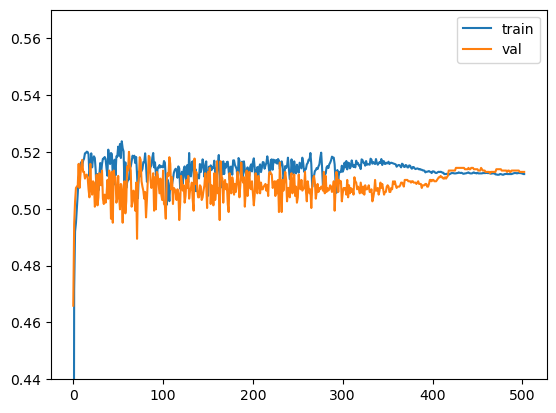

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_accuracies[1:])), train_accuracies[1:], label = "train")
plt.plot(np.arange(len(train_accuracies[1:])), val_accuracies[1:], label = "val")
plt.legend(loc="best")
plt.ylim(0.44, 0.57)
plt.show()

In [10]:
torch.save(best_state, "MCPstable_params_best_r_1")
torch.save(net.state_dict(), "MCPstable_params_last")

In [22]:
net.load_state_dict(torch.load("MCPstable_params_last"))
print(accuracy_score(torch.argmax(net(torch.Tensor(train_data.replace({np.nan:0.0}).values)), axis=1), torch.argmax(torch.tensor(train_scores.iloc[m,:].values), axis=1)))

0.5124246987951807


In [23]:
train_team = train_home_team_statistics_df.iloc[:,2:].join(train_away_team_statistics_df.iloc[:,2:])

team_model = MatchTeamClassifier(3, 280, 64)
team_model.load_state_dict(torch.load("MCTstable_params_last"))
print(accuracy_score(torch.argmax(team_model(torch.Tensor(train_team.replace({np.nan:0.0}).values)), axis=1), torch.argmax(torch.tensor(train_scores.values), axis=1)))

0.5019101032268553


In [24]:
test_away_team_statistics_df = pd.read_csv('./test_away_team_statistics_df.csv', index_col=0)
test_home_team_statistics_df = pd.read_csv('./test_home_team_statistics_df.csv', index_col=0)

test_home_team_statistics_df.columns = 'HOME_' + test_home_team_statistics_df.columns
test_away_team_statistics_df.columns = 'AWAY_' + test_away_team_statistics_df.columns

test_team_data = test_home_team_statistics_df.join(test_away_team_statistics_df)

In [30]:
import pickle

test_home_player_statistics_df = pd.read_csv('./test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('./test_away_player_statistics_df.csv', index_col=0)

lin_model_position = pickle.load(open("pos_model", "rb"))
encoding = ["attacker", "defender", "goalkeeper", "midfielder"]


test_home_player_statistics_df.loc[test_home_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(test_home_player_statistics_df.iloc[:,1:].replace({np.nan:0.0}))])[test_home_player_statistics_df.isna()["POSITION"]]
test_away_player_statistics_df.loc[test_away_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(test_away_player_statistics_df.iloc[:,1:].replace({np.nan:0.0}))])[test_away_player_statistics_df.isna()["POSITION"]]

df = test_away_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_away = df.set_index("ID").groupby("POSITION")
positions = ["attacker", "goalkeeper", "midfielder", "defender"]
m1 = np.intersect1d(gb_away.get_group(positions[0]).index, gb_away.get_group(positions[1]).index)
m2 = np.intersect1d(gb_away.get_group(positions[2]).index, gb_away.get_group(positions[3]).index)
away_m = np.intersect1d(m1, m2)

df = test_home_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_home = df.set_index("ID").groupby("POSITION")
m1 = np.intersect1d(gb_home.get_group(positions[0]).index, gb_home.get_group(positions[1]).index)
m2 = np.intersect1d(gb_home.get_group(positions[2]).index, gb_home.get_group(positions[3]).index)
home_m = np.intersect1d(m1, m2)

m = np.intersect1d(away_m, home_m)

test_player_data = []
useless_features = open("lines.txt", "r").readlines()
useless_features = [ft[:-1] for ft in useless_features]
print(useless_features)
for pos in positions:
    df_home_pos = gb_home.get_group(pos).drop(useless_features, axis=1)
    df_away_pos = gb_away.get_group(pos).drop(useless_features, axis=1)
    df_home_pos.columns = 'HOME_' + df_home_pos.columns
    df_away_pos.columns = 'AWAY_' + df_away_pos.columns
    test_player_data.append(df_home_pos.iloc[:,1:].join(df_away_pos.iloc[:,1:]))

test_player_data[0].columns = "ATTACK_" + test_player_data[0].columns
test_player_data[1].columns = "GOALKEEP_" + test_player_data[1].columns
test_player_data[2].columns = "MIDFIELD_" + test_player_data[2].columns
test_player_data[3].columns = "DEFEND_" + test_player_data[3].columns

#m = m-test_home_team_statistics_df.index[0]
#print(m)
test_data = test_home_team_statistics_df.loc[m,:].join(test_away_team_statistics_df.loc[m,:].join(test_player_data[0].loc[m,:].join(test_player_data[1].loc[m,:].join(test_player_data[2].loc[m,:].join(test_player_data[3].loc[m,:])))))

select_fts = open("feature_selection.txt", "r").readlines()
select_fts = [ft[:-1] for ft in select_fts]
test_data = test_data[select_fts]
print(test_data)

['PLAYER_CAPTAIN_5_last_match_average', 'PLAYER_CAPTAIN_5_last_match_std', 'PLAYER_CAPTAIN_season_average', 'PLAYER_CAPTAIN_season_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_average', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_sum', 'PLAYER_LONG_BALLS_5_last_match_average', 'PLAYER_LONG_BALLS_5_last_match_std', 'PLAYER_LONG_BALLS_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_5_last_match_average', 'PLAYER_LONG_BALLS_WON_5_last_match_std', 'PLAYER_LONG_BALLS_WON_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_season_average', 'PLAYER_LONG_BALLS_WON_season_std', 'PLAYER_LONG_BALLS_WON_season_sum', 'PLAYER_LONG_BALLS_season_average', 'PLAYER_LONG_BALLS_season_std', 'PLAYER_LONG_BALLS_season_sum', 'PLAYER_PENALTIES_SAVED_5_last_match_average', 'PLAYER_PENALTIES_SAVED_5_last_match_std', 'PLAYER_PENALTIES_SAVED_5_last_match_sum', 'PLAYER_PENALTIES_SAVED_season_average', 'PLAYER_PENALTIES_SAVED_season_std', 'PLAYER_PENALTIES_SAVED_season_sum', 'PLAYER_PENALTIE

In [32]:
net.eval()
d = {'HOME_WINS':[0 for i in range(len(test_home_team_statistics_df))], 'DRAW':[0 for i in range(len(test_home_team_statistics_df))], "AWAY_WINS":[0 for i in range(len(test_home_team_statistics_df))]}
test_score = pd.DataFrame(data=d, index=test_home_team_statistics_df.index)
y_pred = net(torch.Tensor(test_data.replace({np.nan:0.0}).values))
scores = torch.argmax(y_pred, axis=1)
test_score.iloc[m[scores == 0]-test_home_team_statistics_df.index[0], 0] = 1
test_score.iloc[m[scores == 1]-test_home_team_statistics_df.index[0], 1] = 1
test_score.iloc[m[scores == 2]-test_home_team_statistics_df.index[0], 2] = 1
print(scores, m-test_home_team_statistics_df.index[0])

y_pred = team_model(torch.Tensor(test_team_data.replace({np.nan:0.0}).values))
team_scores = np.array(torch.argmax(y_pred, axis=1))
test_score.iloc[(test_score["HOME_WINS"] == 0) & (test_score["DRAW"] == 0) & (test_score["AWAY_WINS"] == 0) & (team_scores == 0), 0] = 1
test_score.iloc[(test_score["HOME_WINS"] == 0) & (test_score["DRAW"] == 0) & (test_score["AWAY_WINS"] == 0) & (team_scores == 1), 1] = 1
test_score.iloc[(test_score["HOME_WINS"] == 0) & (test_score["DRAW"] == 0) & (test_score["AWAY_WINS"] == 0) & (team_scores == 2), 2] = 1

test_score.reset_index(inplace=True)
test_score.to_csv("MCPstable.csv", index=False)

tensor([0, 2, 0,  ..., 0, 0, 0]) [    0     1     2 ... 25365 25366 25367]


In [19]:
d = {'HOME_WINS':[0 for i in range(len(test_data))], 'DRAW':[0 for i in range(len(test_data))], "AWAY_WINS":[0 for i in range(len(test_data))]}
test_score = pd.DataFrame(data=d, index=test_home_team_statistics_df.index)

y_pred = net(torch.Tensor(test_data.replace({np.nan:0.0}).values))
team_scores = torch.argmax(y_pred, axis=1)
print(team_scores)
test_score.iloc[team_scores == 0, 0] = 1
test_score.iloc[team_scores == 1, 1] = 1
test_score.iloc[team_scores == 2, 2] = 1

test_score.reset_index(inplace=True)
test_score.to_csv("MCPstable.csv", index=False)

tensor([0, 2, 0,  ..., 0, 0, 0])
